# Tutorial: JAX 101

## JAX as accelerated NumPy

In [1]:
import jax
import jax.numpy as jnp

x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [2]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

7.38 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
# Compare to NumPy
import numpy as np

long_vector = jnp.arange(int(1e7))

%timeit np.dot(long_vector, long_vector)


8.32 ms ± 81.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### JAX first transformations: `grad`

In [4]:
def sum_of_squares(x):
    return jnp.sum(x**2)

In [5]:
sum_of_squares_dx = jax.grad(sum_of_squares)

In [6]:
x = jnp.asarray([1.0, 2.0, 3.0, 4.0])

print(sum_of_squares(x))
print(sum_of_squares_dx(x))

30.0
[2. 4. 6. 8.]


In [7]:
# Gradient wrt to multiple arguments
def sum_squared_error(x, y):
    return jnp.sum((x-y)**2)

sum_squared_error_dx = jax.grad(sum_squared_error, argnums=(0, 1))

y = jnp.asarray([1.1, 2.1, 3.1, 4.1])

sum_squared_error_dx(x, y)

(Array([-0.20000005, -0.19999981, -0.19999981, -0.19999981], dtype=float32),
 Array([0.20000005, 0.19999981, 0.19999981, 0.19999981], dtype=float32))

### First JAX training loop

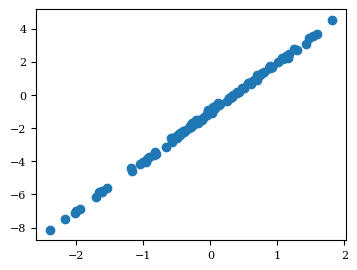

In [8]:
import numpy as np
import matplotlib.pyplot as plt

xs = np.random.normal(size=(100,))
noise = np.random.normal(scale=0.1, size=(100,))
ys = xs * 3 - 1 + noise

plt.scatter(xs, ys);


In [9]:
def model(theta, x):
  """Computes wx + b on a batch of input x."""
  w, b = theta
  return w * x + b

In [10]:
import jax.numpy as jnp

def loss_fn(theta, x, y):
  prediction = model(theta, x)
  return jnp.mean((prediction-y)**2)

In [11]:
import jax

def update(theta, x, y, lr=0.1):
  return theta - lr * jax.grad(loss_fn)(theta, x, y)

w: 2.98, b: -1.02


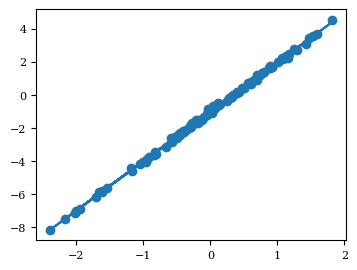

In [12]:
theta = jnp.array([1., 1.])

for _ in range(1000):
  theta = update(theta, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, model(theta, xs))

w, b = theta
print(f"w: {w:<.2f}, b: {b:<.2f}")

## JIT with JAX

### How JAX transforms work

In [13]:
import jax
import jax.numpy as jnp

global_list = []

def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In [14]:
def log2_if_rank_2(x):
  if x.ndim == 2:
    ln_x = jnp.log(x)
    ln_2 = jnp.log(2.0)
    return ln_x / ln_2
  else:
    return x

In [15]:
print(jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([1, 2, 3])))

{ lambda ; a:i32[3]. let  in (a,) }


In [17]:
print(jax.make_jaxpr(log2_if_rank_2)(jax.numpy.array([1.0, 2.0, 3.0]).reshape((1, -1))))

{ lambda ; a:f32[1,3]. let
    b:f32[1,3] = log a
    c:f32[] = log 2.0
    d:f32[] = convert_element_type[new_dtype=float32 weak_type=False] c
    e:f32[1,3] = div b d
  in (e,) }


### JIT compiling a function

In [18]:
import jax
import jax.numpy as jnp

def selu(x, alpha=1.67, lambda_=1.05):
  return lambda_ * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

5.1 ms ± 68.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
# JIT compile before call
selu_jit = jax.jit(selu)

%timeit selu_jit(x).block_until_ready()

760 µs ± 30.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


### Why can’t we just JIT everything?

In [23]:
# JIT does NOT work:
# Condition on value of x.

def f(x):
  if x > 0:
    return x
  else:
    return 2 * x

f_jit = jax.jit(f)
f_jit(10)  # Should raise an error. 

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at /tmp/ipykernel_111893/2760793458.py:4 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [26]:
# Condition on constant value in outer scope

FLAG = 1

def f(x):
    if FLAG == 0:
        return x*2.0
    else:
        return x
    
f_jit = jax.jit(f)

print(jax.make_jaxpr(f)(10))

{ lambda ; a:i32[]. let  in (a,) }


In [27]:
FLAG = 0
print(jax.make_jaxpr(f)(10))

{ lambda ; a:i32[]. let
    b:f32[] = convert_element_type[new_dtype=float32 weak_type=True] a
    c:f32[] = mul b 2.0
  in (c,) }


In [28]:
FLAG = 0
f_jit = jax.jit(f)

f_jit(10)

Array(20., dtype=float32, weak_type=True)

## Automatic Vectorization in JAX

### Manual Vectorization

In [29]:
import jax
import jax.numpy as jnp

x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

convolve(x, w)

Array([11., 20., 29.], dtype=float32)

In [30]:
xs = jnp.stack([x, x])
ws = jnp.stack([w, w])

In [31]:
def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

manually_batched_convolve(xs, ws)


Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

### Automatic Vectorization

In [32]:
auto_batch_convolve = jax.vmap(convolve)

auto_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

In [34]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)

jitted_batch_convolve(xs, ws)

Array([[11., 20., 29.],
       [11., 20., 29.]], dtype=float32)

## Advanced Automatic Differentiation in JAX

### Higher-order derivatives

In [35]:
import jax

f = lambda x: x**3 + 2*x**2 - 3*x + 1

dfdx = jax.grad(f)